In [1]:

import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import torch
import math
import networkx as nx
from tqdm import tqdm
from PIL import Image
import json
from crp.image import imgify, vis_opaque_img, plot_grid

In [37]:
from expbasics.nmf import sample_cavs, nmf, nearest_neighbors, vis_nearest_neighbors, load_cavs, sample_relevance_cavs, sample_bbox_cavs, sample_all_relevances_cavs
from expbasics.helper import get_attributions, get_model_etc, to_name
from expbasics.visualizations import plot_nmfs
from expbasics.dim_reduction import visualize_dr, get_dr_methods, clean_centroids, centroid_distances


%reload_ext autoreload
%autoreload 2

In [3]:
BIAS = 0.97
NUM_IT = 0
MODEL_NAME = to_name(BIAS, NUM_IT)
model, gm, crp_attribution, unbiased_ds, test_loader = get_model_etc(BIAS, NUM_IT)


In [68]:
BATCH_SIZE = 512 # 128
N_BASIS = 4
BATCH_STEP_SIZE = 256
NUM_NEIGHBORS = 36
SPATIAL_STEPSIZE = 7
LAYER_NAME = "convolutional_layers.6" #"linear_layers.1"#
# sample activations:
#sample_cavs(model, unbiased_ds, LAYER_NAME, SPATIAL_STEPSIZE, BATCH_STEP_SIZE, BATCH_SIZE, model_name)
#sample_relevance_cavs(model, unbiased_ds, LAYER_NAME, SPATIAL_STEPSIZE, BATCH_STEP_SIZE, BATCH_SIZE, crp_attribution, MODEL_NAME)
sample_all_relevances_cavs(model, unbiased_ds, LAYER_NAME, SPATIAL_STEPSIZE, BATCH_STEP_SIZE, BATCH_SIZE, crp_attribution, MODEL_NAME)
cavs, idx, _ = load_cavs(LAYER_NAME, MODEL_NAME, "all")
H = nmf(cavs, N_BASIS)
H = torch.tensor(H)
print(H.shape)

nn_idx = nearest_neighbors(H, cavs, idx, NUM_NEIGHBORS, "cosine")  # , "cosine"
for i in range(N_BASIS):
    vis_nearest_neighbors(unbiased_ds, nn_idx[i], f"{LAYER_NAME}_cosine_{i}")

Computing CAVs: 100%|██████████| 960/960 [00:38<00:00, 24.82batch/s]
/home/lilli/Desktop/MASTER/code/experiments/expbasics/nmf.py:316: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  H = torch.tensor(H, dtype=torch.float32)


torch.Size([4, 30])


In [83]:
H[0][16:24].shape

torch.Size([8])

In [84]:
cond_layer = "convolutional_layers.6"#"linear_layers.0" #

t = torch.zeros((N_BASIS, NUM_NEIGHBORS, 64, 64))
told = torch.zeros((N_BASIS, NUM_NEIGHBORS, 64, 64))
originals = torch.zeros((N_BASIS, NUM_NEIGHBORS, 64, 64))
for i in range(N_BASIS):
    for index in range(NUM_NEIGHBORS):
        hold, pred = crp_attribution.heatmap(nn_idx[i][index])
        h = crp_attribution.cav_heatmap(nn_idx[i][index], cond_layer, H[i][16:24])
        #h = crp_attribution.old_cav_heatmap(nn_idx[i][index], cond_layer, H[i])
        originals[i][index] = crp_attribution.dataset[nn_idx[i][index]][0][0]
        t[i][index] = h
        told[i][index] = hold

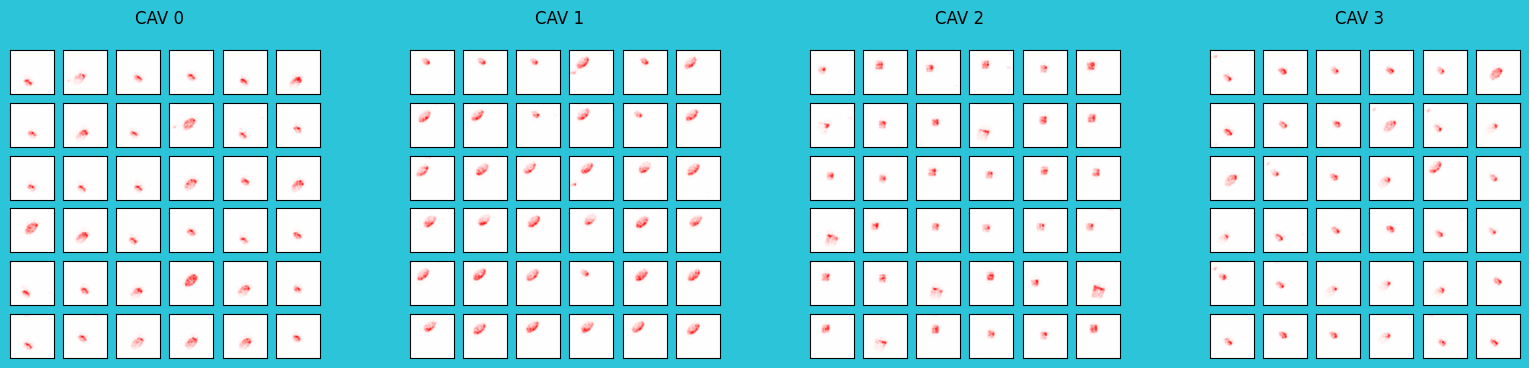

In [85]:
plot_nmfs(t, NUM_NEIGHBORS, N_BASIS)

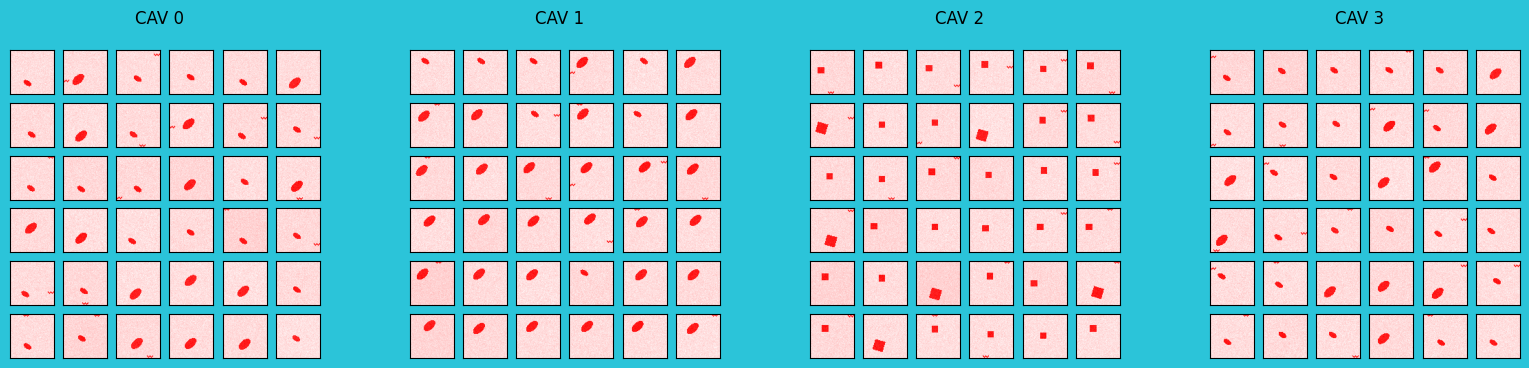

In [71]:
plot_nmfs(originals, NUM_NEIGHBORS, N_BASIS) # NUM_NEIGHBORS, N_BASIS

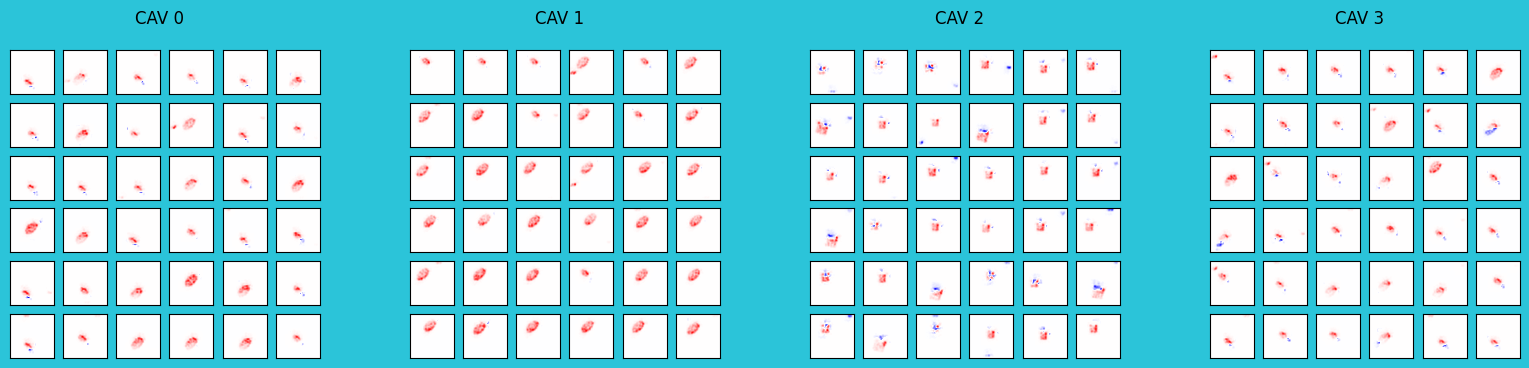

In [72]:
plot_nmfs(told, NUM_NEIGHBORS, N_BASIS)

In [98]:
sample_bbox_cavs(model, LAYER_NAME, crp_attribution, MODEL_NAME)

Computing CAVs: 100%|██████████| 443/443 [00:09<00:00, 46.83img/s]


In [23]:
imgs,ts = next(iter(test_loader))
#imgs.shape
res = crp_attribution.attribute_images(imgs, LAYER_NAME)
res.shape

torch.Size([128, 8, 7, 7])

In [54]:
res = crp_attribution.attribute_all_layers(imgs)

array([[-13.94987583, -23.79485321],
       [-42.68114471,  -0.84221041],
       [-28.54146576,   9.37975502],
       [-36.46912384,   7.51798534],
       [         nan,          nan],
       [ 41.02280807, -10.36789131],
       [ 21.1615181 ,  24.80280685],
       [ 16.15089989,  14.43179131]])

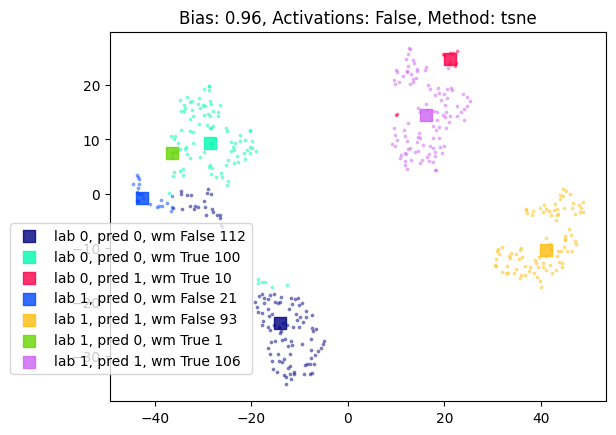

In [99]:
bbox_cavs, idx, infos = load_cavs(LAYER_NAME, MODEL_NAME, "bb")
methods, names = get_dr_methods()

labels = np.array([i[0] for i in infos.values()])
watermarks = np.array([int(i[1]) for i in infos.values()])
preds = np.array([i[2] for i in infos.values()])
visualize_dr(methods, names, bbox_cavs, watermarks, labels, preds, BIAS, False, NUM_IT, 0, LAYER_NAME)


In [146]:
BIASES = list(np.round(np.linspace(0.5, 1.0, 26), 3))
for bias in (pbar := tqdm(BIASES)):
    pbar.set_postfix(
        bias=str(bias),
    )
    for num_it in range(1,4):
        name = to_name(bias, num_it)
        print(name)
        model, gm, crp_attribution, unbiased_ds, test_loader = get_model_etc(
            bias, num_it=num_it
        )
        sample_bbox_cavs(model, LAYER_NAME, crp_attribution, name)

  0%|          | 0/26 [00:00<?, ?it/s, bias=0.5]

b0_5-i1


Computing CAVs: 100%|██████████| 443/443 [00:09<00:00, 46.20img/s]


b0_5-i2


Computing CAVs: 100%|██████████| 443/443 [00:11<00:00, 39.49img/s]


b0_5-i3


  4%|▍         | 1/26 [00:32<13:30, 32.41s/it, bias=0.52]

b0_52-i1


Computing CAVs: 100%|██████████| 443/443 [00:11<00:00, 38.31img/s]


b0_52-i2


Computing CAVs: 100%|██████████| 443/443 [00:13<00:00, 32.87img/s]


b0_52-i3


  8%|▊         | 2/26 [01:09<13:59, 34.99s/it, bias=0.54]

b0_54-i1


Computing CAVs: 100%|██████████| 443/443 [00:14<00:00, 31.27img/s]


b0_54-i2


Computing CAVs: 100%|██████████| 443/443 [00:14<00:00, 30.20img/s]


b0_54-i3


 12%|█▏        | 3/26 [01:51<14:37, 38.17s/it, bias=0.56]

b0_56-i1


Computing CAVs: 100%|██████████| 443/443 [00:14<00:00, 29.84img/s]


b0_56-i2


Computing CAVs: 100%|██████████| 443/443 [00:13<00:00, 32.80img/s]


b0_56-i3


 15%|█▌        | 4/26 [02:34<14:47, 40.35s/it, bias=0.58]

b0_58-i1


Computing CAVs: 100%|██████████| 443/443 [00:13<00:00, 31.71img/s]


b0_58-i2


Computing CAVs: 100%|██████████| 443/443 [00:14<00:00, 30.95img/s]


b0_58-i3


 19%|█▉        | 5/26 [03:18<14:31, 41.52s/it, bias=0.6] 

b0_6-i1


Computing CAVs: 100%|██████████| 443/443 [00:13<00:00, 32.25img/s]


b0_6-i2


Computing CAVs: 100%|██████████| 443/443 [00:14<00:00, 30.91img/s]


b0_6-i3


 23%|██▎       | 6/26 [04:01<13:57, 41.89s/it, bias=0.62]

b0_62-i1


Computing CAVs: 100%|██████████| 443/443 [00:13<00:00, 32.41img/s]


b0_62-i2


Computing CAVs: 100%|██████████| 443/443 [00:14<00:00, 29.62img/s]


b0_62-i3


 27%|██▋       | 7/26 [04:45<13:31, 42.70s/it, bias=0.64]

b0_64-i1


Computing CAVs: 100%|██████████| 443/443 [00:17<00:00, 25.31img/s]


b0_64-i2


Computing CAVs: 100%|██████████| 443/443 [00:16<00:00, 27.48img/s]


b0_64-i3


 31%|███       | 8/26 [05:35<13:29, 45.00s/it, bias=0.66]

b0_66-i1


Computing CAVs: 100%|██████████| 443/443 [00:14<00:00, 30.20img/s]


b0_66-i2


Computing CAVs: 100%|██████████| 443/443 [00:15<00:00, 28.30img/s]


b0_66-i3


 35%|███▍      | 9/26 [06:21<12:52, 45.45s/it, bias=0.68]

b0_68-i1


Computing CAVs: 100%|██████████| 443/443 [00:15<00:00, 28.58img/s]


b0_68-i2


Computing CAVs: 100%|██████████| 443/443 [00:15<00:00, 29.32img/s]


b0_68-i3


 38%|███▊      | 10/26 [07:09<12:16, 46.04s/it, bias=0.7] 

b0_7-i1


Computing CAVs: 100%|██████████| 443/443 [00:16<00:00, 27.66img/s]


b0_7-i2


Computing CAVs: 100%|██████████| 443/443 [00:15<00:00, 28.61img/s]


b0_7-i3


 42%|████▏     | 11/26 [07:56<11:36, 46.46s/it, bias=0.72]

b0_72-i1


Computing CAVs: 100%|██████████| 443/443 [00:15<00:00, 28.73img/s]


b0_72-i2


Computing CAVs: 100%|██████████| 443/443 [00:16<00:00, 27.62img/s]


b0_72-i3


 46%|████▌     | 12/26 [08:44<10:55, 46.84s/it, bias=0.74]

b0_74-i1


Computing CAVs: 100%|██████████| 443/443 [00:16<00:00, 26.49img/s]


b0_74-i2


Computing CAVs: 100%|██████████| 443/443 [00:16<00:00, 27.19img/s]


b0_74-i3


 50%|█████     | 13/26 [09:33<10:20, 47.71s/it, bias=0.76]

b0_76-i1


Computing CAVs: 100%|██████████| 443/443 [00:15<00:00, 29.08img/s]


b0_76-i2


Computing CAVs: 100%|██████████| 443/443 [00:15<00:00, 29.41img/s]


b0_76-i3


 54%|█████▍    | 14/26 [10:19<09:24, 47.03s/it, bias=0.78]

b0_78-i1


Computing CAVs: 100%|██████████| 443/443 [00:13<00:00, 31.88img/s]


b0_78-i2


Computing CAVs: 100%|██████████| 443/443 [00:15<00:00, 28.59img/s]


b0_78-i3


 58%|█████▊    | 15/26 [11:04<08:29, 46.35s/it, bias=0.8] 

b0_8-i1


Computing CAVs: 100%|██████████| 443/443 [00:14<00:00, 30.27img/s]


b0_8-i2


Computing CAVs: 100%|██████████| 443/443 [00:15<00:00, 29.12img/s]


b0_8-i3


 62%|██████▏   | 16/26 [11:49<07:39, 45.92s/it, bias=0.82]

b0_82-i1


Computing CAVs: 100%|██████████| 443/443 [00:14<00:00, 30.66img/s]


b0_82-i2


Computing CAVs: 100%|██████████| 443/443 [00:16<00:00, 27.52img/s]


b0_82-i3


 65%|██████▌   | 17/26 [12:35<06:53, 45.94s/it, bias=0.84]

b0_84-i1


Computing CAVs: 100%|██████████| 443/443 [00:14<00:00, 31.32img/s]


b0_84-i2


Computing CAVs: 100%|██████████| 443/443 [00:13<00:00, 31.92img/s]


b0_84-i3


 69%|██████▉   | 18/26 [13:17<05:59, 44.96s/it, bias=0.86]

b0_86-i1


Computing CAVs: 100%|██████████| 443/443 [00:14<00:00, 31.29img/s]


b0_86-i2


Computing CAVs: 100%|██████████| 443/443 [00:14<00:00, 29.58img/s]


b0_86-i3


 73%|███████▎  | 19/26 [14:01<05:11, 44.51s/it, bias=0.88]

b0_88-i1


Computing CAVs: 100%|██████████| 443/443 [00:13<00:00, 31.70img/s]


b0_88-i2


Computing CAVs: 100%|██████████| 443/443 [00:13<00:00, 31.73img/s]


b0_88-i3


 77%|███████▋  | 20/26 [14:43<04:23, 43.92s/it, bias=0.9] 

b0_9-i1


Computing CAVs: 100%|██████████| 443/443 [00:14<00:00, 31.00img/s]


b0_9-i2


Computing CAVs: 100%|██████████| 443/443 [00:16<00:00, 26.77img/s]


b0_9-i3


 81%|████████  | 21/26 [15:34<03:49, 45.94s/it, bias=0.92]

b0_92-i1


Computing CAVs: 100%|██████████| 443/443 [00:18<00:00, 23.67img/s]


b0_92-i2


Computing CAVs: 100%|██████████| 443/443 [00:16<00:00, 27.58img/s]


b0_92-i3


 85%|████████▍ | 22/26 [16:24<03:09, 47.31s/it, bias=0.94]

b0_94-i1


Computing CAVs: 100%|██████████| 443/443 [00:14<00:00, 31.41img/s]


b0_94-i2


Computing CAVs: 100%|██████████| 443/443 [00:14<00:00, 29.62img/s]


b0_94-i3


 88%|████████▊ | 23/26 [17:09<02:19, 46.39s/it, bias=0.96]

b0_96-i1


Computing CAVs: 100%|██████████| 443/443 [00:14<00:00, 29.97img/s]


b0_96-i2


Computing CAVs: 100%|██████████| 443/443 [00:14<00:00, 30.81img/s]


b0_96-i3


 92%|█████████▏| 24/26 [17:53<01:31, 45.81s/it, bias=0.98]

b0_98-i1


Computing CAVs: 100%|██████████| 443/443 [00:14<00:00, 30.33img/s]


b0_98-i2


Computing CAVs: 100%|██████████| 443/443 [00:15<00:00, 29.16img/s]


b0_98-i3


 96%|█████████▌| 25/26 [18:39<00:45, 45.78s/it, bias=1.0] 

b1_0-i1


Computing CAVs: 100%|██████████| 443/443 [00:15<00:00, 29.45img/s]


b1_0-i2


Computing CAVs: 100%|██████████| 443/443 [00:14<00:00, 29.55img/s]


b1_0-i3


100%|██████████| 26/26 [19:24<00:00, 44.79s/it, bias=1.0]


100%|██████████| 26/26 [01:24<00:00,  3.24s/it, num_it=3] 


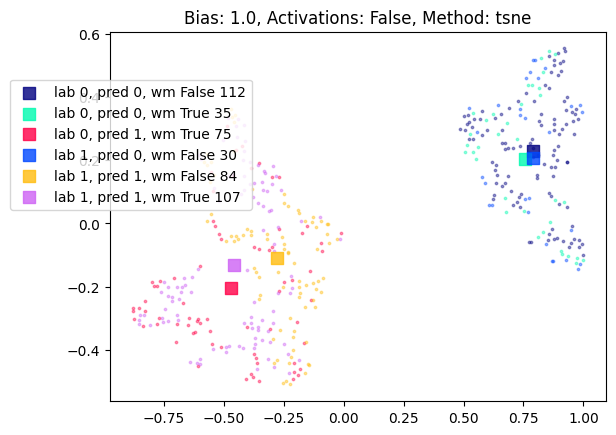

In [87]:
methods, names = get_dr_methods()
all_centroids = {}
concept_means = {}
BIASES = list(np.round(np.linspace(0.5, 1.0, 26), 3))

for bias in (pbar := tqdm(BIASES)):
    pbar.set_postfix(
        bias=str(bias),
    )
    for num_it in range(4):
        pbar.set_postfix(
            num_it=str(num_it),
        )
        name = to_name(bias, num_it)
        bbox_cavs, idx, infos = load_cavs(LAYER_NAME, name, "bb")
        if len(idx) < 1:
            print("no data")

        labels = np.array([i[0] for i in infos.values()])
        watermarks = np.array([int(i[1]) for i in infos.values()])
        preds = np.array([i[2] for i in infos.values()])
        centroids, full_centroids = visualize_dr(
            methods,
            names,
            bbox_cavs,
            watermarks,
            labels,
            preds,
            bias,
            False,
            num_it,
            0,
            "bbox_rels",
        )
        all_centroids[str(bias)] = full_centroids
        concept_means[name] = full_centroids.tolist()

with open("outputs/bbox_cavs_centroids.json", "w") as f:
    json.dump(concept_means, f, indent=2)

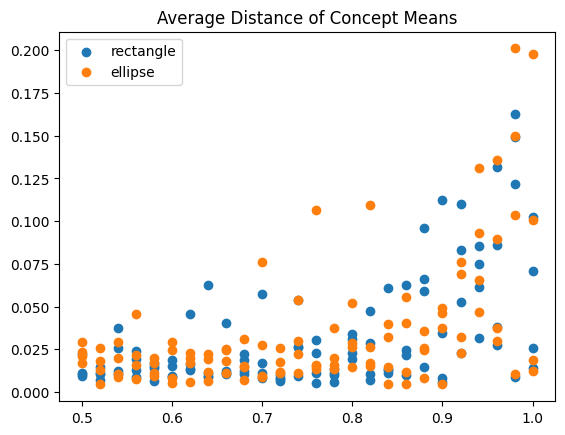

In [91]:
concepts_named = clean_centroids(concept_means)
biases = [b for b  in BIASES  for i in range(4)]

res = centroid_distances(concepts_named, biases)

In [1]:
L1  https://transformer-circuits.pub/2023/monosemantic-features

TCAV -> 

multipliziere activations in latent space mit basisvektoren 
https://arxiv.org/abs/2303.12641

SyntaxError: invalid syntax (911830306.py, line 1)